# This Notebook is for Time Series Prediction for Bitcoin Prices

# Dataset is taken from https://www.coindesk.com/price/bitcoin

In [1]:
#Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import os
from sklearn.preprocessing import minmax_scale

In [2]:
#Loading the Dataset
#Tell pandas that the first column is datetime
df = pd.read_csv('BTC_USD_2013-10-01_2021-06-02-CoinDesk.csv', parse_dates=['Date'], index_col=['Date']) 
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
#Looking at more information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2801 entries, 2013-10-01 to 2021-06-02
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2801 non-null   object 
 1   Closing Price (USD)  2801 non-null   float64
 2   24h Open (USD)       2801 non-null   float64
 3   24h High (USD)       2801 non-null   float64
 4   24h Low (USD)        2801 non-null   float64
dtypes: float64(4), object(1)
memory usage: 131.3+ KB


In [4]:
#Getting only the closing prices for everyday
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


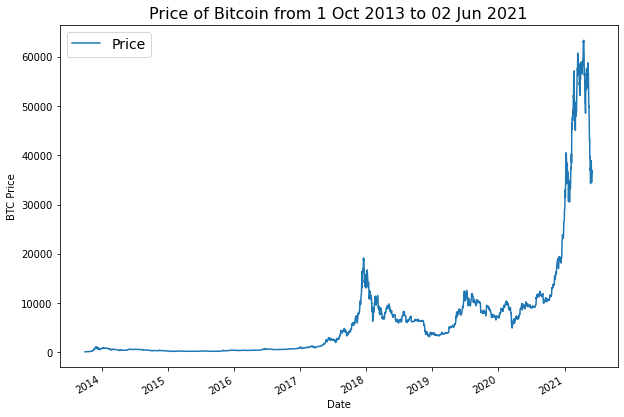

In [5]:
#Plotting all the prices to get a better look
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 02 Jun 2021", fontsize=16)
plt.legend(fontsize=14);

In [130]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("BTC_USD_2013-10-01_2021-06-02-CoinDesk.csv", "r") as f:
    csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
    next(csv_reader) # skip first line (this gets rid of the column titles)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
        btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

In [6]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [7]:
#Splitting the Dataset into Train and Test set
#In Time-seires problems splitting the dataset the normal way, which is randomly selecting 80-20 split is wrong!
#We aim to train our model on past data and hope it works on the artificial future data
#Thus splitting the dataset the orthodox way makes no sense
#Instead we create the training set as the first 80% samples and the Test set as the remaining 20% as follows


split_size = int(0.8 * len(prices)) # 80% train, 20% test

#Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

#Create Test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

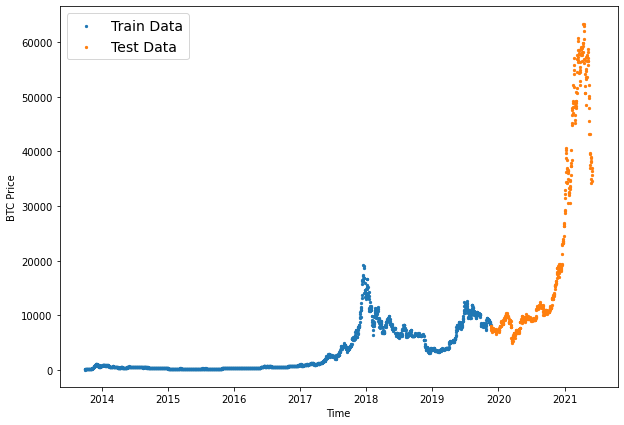

In [8]:
#Plotting the splits
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label='Train Data')
plt.scatter(X_test, y_test, s=5, label='Test Data')
plt.xlabel("Time")
plt.ylabel("BTC Price")
plt.legend(fontsize=14);
plt.show()

In [9]:
#Creating a plotting fucntion
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=14);
    plt.grid(True)

Naive Model (Baseline)

In [10]:
#creating a naive forecast
naive_forecast = y_test[:-1]
naive_forecast[:10]

array([8118.4885358 , 8074.84317361, 7612.7405735 , 7262.11053495,
       7303.40575852, 7041.73293642, 7211.86180875, 7141.06944869,
       7523.4806726 , 7390.20746923])

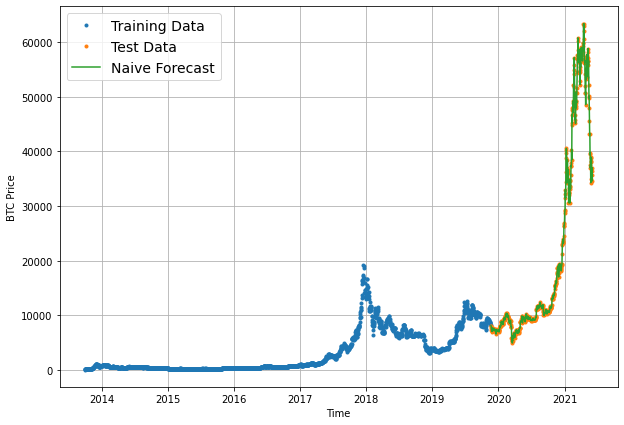

In [11]:
#Plotting the naive Forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, format=".", label='Training Data')
plot_time_series(timesteps=X_test, values=y_test, format=".",  label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast,format="-", label='Naive Forecast')

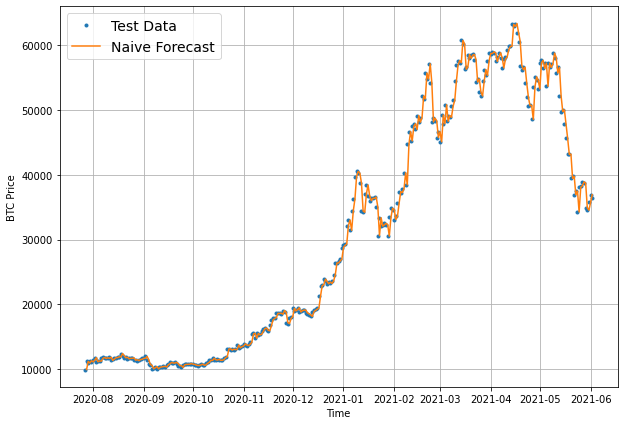

In [12]:
#zooming in on the test and naive forecast
plt.figure(figsize=(10,7))
offset=250
plot_time_series(timesteps=X_test, values=y_test, format=".", start=offset, label='Test Data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast,format="-", start=offset, label='Naive Forecast')

In [13]:
#Code snippet for MASE 

def mean_absolute_scaled_error(y_true, y_pred):
    #Implement MASE (assuming no seasonality of data)
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
    return mae / mae_naive_no_season

In [14]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    #Calculate different evaluation metrics
    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)
    
    # Account for different sized metrics (for longer horizons, reduce to single number)
    if mae.ndim > 0:
        # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {'mae': mae.numpy(),
           'mse': mse.numpy(),
           'rmse': rmse.numpy(),
           'mape': mape.numpy(),
            'mase': mase.numpy()}

In [15]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 602.0485,
 'mse': 1258207.5,
 'rmse': 1121.6985,
 'mape': 2.5736644,
 'mase': 0.99834347}

In [16]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [17]:
#Function to label windowed data
def get_labelled_windows(x, horizon=1):
    # example Input: [1,2,3,4,5,6] -> output: ([1,2,3,4,5], [6])
    return x[:, :-horizon], x[:, -horizon:]

In [18]:
#function to view numpy arrays as windows
def make_windows(x, window_size=7, horizon=1):
    #Turns a 1D array into a 2D array of sequential windows of window_size.
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0) # create 2D array of window_size
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    windowed_array = x[window_indexes] # get the original array indexed with windows
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    return windows, labels

In [19]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2794, 2794)

In [20]:
# Making the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [21]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2235, 559, 2235, 559)

In [22]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [23]:
#saving our best results
def create_model_checkpoint(model_name, save_path="model_experiments"):
      return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

In [24]:
len(train_windows), len(test_windows), len(full_windows)

(2235, 559, 2794)

In [25]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_1_dense')

model_1.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_1.fit(x=train_windows, y=train_labels, epochs=100, verbose=0, batch_size=128, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: mod

In [26]:
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
#Evaluating model1
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9508


608.9508056640625

In [27]:
#funstion for making forecast
def make_forecast(model, input_data):
    
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [28]:
model_1_preds = tf.squeeze(model_1.predict(test_windows))
len(model_1_preds)

559

In [29]:
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 608.951,
 'mse': 1288094.1,
 'rmse': 1134.9424,
 'mape': 2.6230147,
 'mase': 1.0093668}

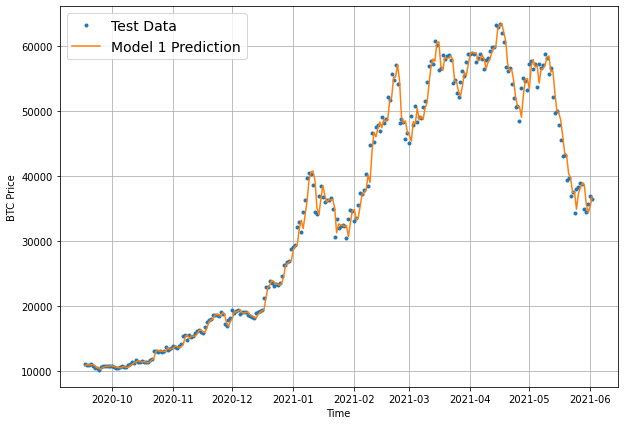

In [30]:
#Plotting model_1 results
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format='.', start=offset, label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds,format='-', start=offset, label='Model 1 Prediction')


In [31]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 30 # use a 30 days worth of timesteps to predict the horizon

In [32]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2771, 2771)

In [33]:
#making train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2216, 555, 2216, 555)

In [34]:
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_2_dense')

model_2.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_2.fit(x=train_windows, y=train_labels, epochs=100, verbose=0, batch_size=128, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [35]:
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
#Evaluating model1
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 791us/step - loss: 643.7311


643.7311401367188

In [36]:
# Get forecast predictions
model_2_preds = make_forecast(model_2, input_data=test_windows)

In [37]:
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 643.73114,
 'mse': 1403219.4,
 'rmse': 1184.5756,
 'mape': 2.7877293,
 'mase': 1.0619661}

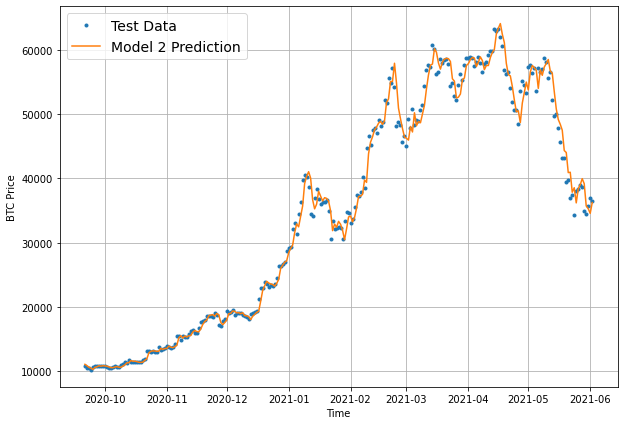

In [38]:
#Plotting model_1 results
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format='.', start=offset, label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds,format='-', start=offset, label='Model 2 Prediction')


Model 3 - Dense model with horizon = 7 and Windows = 30

In [39]:
HORIZON = 7 # predict 7 step at a time
WINDOW_SIZE = 30 # use a 30 days worth of timesteps to predict the horizon

In [40]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2765, 2765)

In [41]:
#making train and test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2212, 553, 2212, 553)

In [42]:
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

model_3.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_3.fit(x=train_windows, y=train_labels, epochs=100, verbose=0, batch_size=128, 
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [43]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense")
#Evaluating model1
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 1359.8004


1359.8004150390625

In [44]:
# Get forecast predictions
model_3_preds = make_forecast(model_3, input_data=test_windows)

In [45]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 1359.8004,
 'mse': 6582194.0,
 'rmse': 1559.1783,
 'mape': 5.7444053,
 'mase': 2.25567}

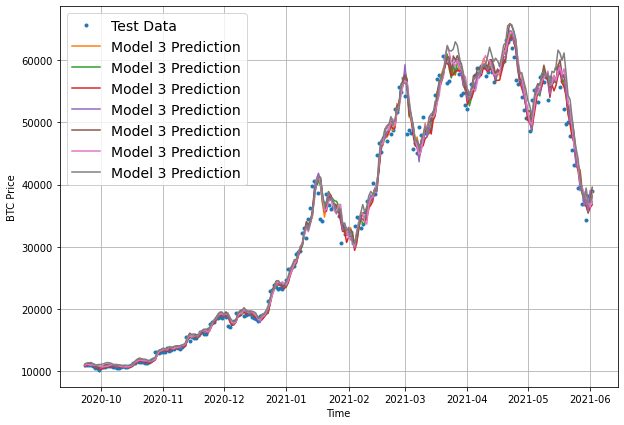

In [46]:
#Plotting model_3 results
offset = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0],format='.', start=offset, label='Test Data')
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,format='-', start=offset, label='Model 3 Prediction')


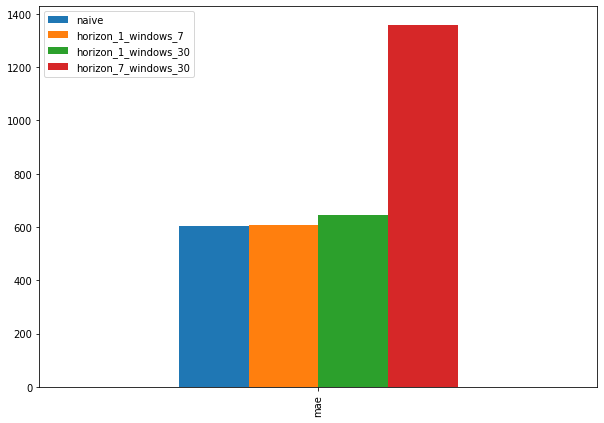

In [47]:
#Comparing our 3 dense models with naive forecast based on mae 
pd.DataFrame({"naive": naive_results["mae"], 
              "horizon_1_windows_7": model_1_results["mae"], 
              "horizon_1_windows_30": model_2_results["mae"], 
              "horizon_7_windows_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

Model 4 - Conv1D - horizon=1 and windows=7

In [48]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [49]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2794, 2794)

In [50]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2235, 559, 2235, 559)

In [51]:
#check the shape for train_windows

train_windows[0].shape

(7,)

In [52]:
#change the shape eg (7, ) -> (7, 1)
x = tf.constant(train_windows[0])
#add an extra dimension for timestamps
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [53]:
# Create model 4
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows, train_labels, batch_size=128, epochs=100, verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [54]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 3ms/step - loss: 603.1299


603.1299438476562

In [55]:
model_4_preds = make_forecast(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8069.023 , 7676.218 , 7309.9077, 7274.9824, 7058.393 , 7142.144 ,
       7155.8047, 7450.908 , 7442.627 , 7694.854 ], dtype=float32)>

In [56]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 603.13,
 'mse': 1272696.5,
 'rmse': 1128.1385,
 'mape': 2.6020594,
 'mase': 0.9997181}

In [57]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            2816      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


Model 5 - RNN (LSTM)


In [58]:
len(train_windows), len(train_labels)

(2235, 2235)

In [59]:
#Create model 
tf.random.set_seed(42)

#Building LSTM model using functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)

x = layers.LSTM(128, activation='relu')(x)

outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name='model_5_lstm')

model_5.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

model_5.fit(train_windows, train_labels, epochs=100, batch_size=128, verbose=0,
           validation_data=(test_windows, test_labels),
           callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
INFO:tensorflow:Assets written to: model_experiment

In [60]:
model_5.summary()

Model: "model_5_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 1s 13ms/step - loss: 625.6770


625.677001953125

In [62]:
model_5_preds = make_forecast(model_5, test_windows)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8087.489 , 7761.887 , 7329.6743, 7261.9185, 7104.147 , 7108.743 ,
       7131.3413, 7422.376 , 7436.23  , 7669.654 ], dtype=float32)>

In [63]:
# Evaluate predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 625.6771,
 'mse': 1353497.8,
 'rmse': 1163.3992,
 'mape': 2.718535,
 'mase': 1.0370911}

Model 6 - cloning Model 1 on multivariate time series data

In [64]:
#Make a multivariate time series for out dataset
#adding another feature column to the dataset
#Reward values - value halved every 4 years

block_reward_1 = 50
block_reward_2 = 25 
block_reward_3 = 12.5 
block_reward_4 = 6.25

#Adding time stamps with 4 years interval
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [65]:
# Get date indexes for when to add in different block dates
#this is done since prices are daily the rewards too have to be daily
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [66]:
#adding th column to the dataset
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


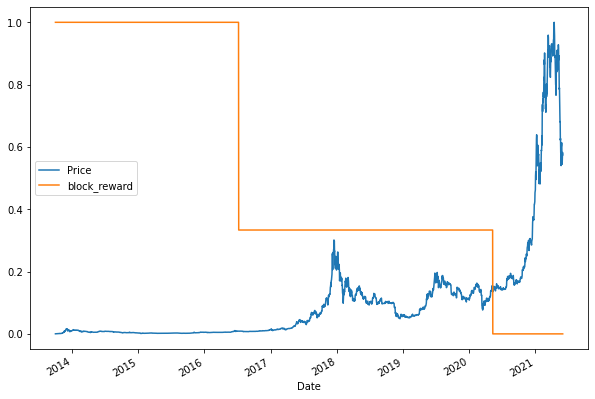

In [67]:
# Plot the block reward/price over time
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [68]:
#making the windowed dataset with pandas
HORIZON = 1
WINDOW_SIZE = 7

In [69]:
bitcoin_prices_windowed = bitcoin_prices_block.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(i+1)
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [70]:
#spearating the prediction values 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [71]:
#splitting into train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2235, 2235, 559, 559)

In [72]:
tf.random.set_seed(42)

X_train = tf.cast(X_train, dtype=tf.float32)
y_train = tf.cast(y_train, dtype=tf.float32)
    
    
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the Naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

model_6.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())


model_6.fit(X_train, y_train, epochs=100, batch_size=128, verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
INFO:tensorflow:Assets written to: model_ex

In [73]:
model_6.summary()

Model: "model_6_dense_multivariate"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 17,793
Trainable params: 17,793
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Evalaute
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 4ms/step - loss: 617.1022


617.1022338867188

In [75]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 604.6630


604.6630249023438

In [76]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8048.192 , 7642.851 , 7273.9478, 7295.1016, 7106.494 , 7202.1763,
       7142.5557, 7472.0967, 7402.308 , 7695.268 ], dtype=float32)>

In [77]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': 604.6629,
 'mse': 1270147.4,
 'rmse': 1127.0082,
 'mape': 2.6210763,
 'mase': 1.002259}

In [78]:
naive_results, model_6_results

({'mae': 602.0485,
  'mse': 1258207.5,
  'rmse': 1121.6985,
  'mape': 2.5736644,
  'mase': 0.99834347},
 {'mae': 604.6629,
  'mse': 1270147.4,
  'rmse': 1127.0082,
  'mape': 2.6210763,
  'mase': 1.002259})

Model 7 - N-BEATS Algorithm

In [95]:
#Creating a NBeatsBlock Custom layer function
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, input_size: int, theta_size: int, horizon: int, n_neurons: int, n_layers: int, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers
        
        #This block contains a stack of 4 fully connected layers
        #Different way to write a for loop in one line
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        #Output of the block is theta with linear activation
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name='theta')
        
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            y = layer(x)
            theta = self.theta_layer(y)
        # Output the backcast and forecast from theta
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [96]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE, theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast 
                                       horizon=HORIZON, n_neurons=128, n_layers=4)

In [97]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [98]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-1.4274161   3.9625466   1.2488292  -2.1726203  -0.54103184 -2.142897
  0.86971104]
Forecast: -0.7953492999076843


In [99]:
#Preparing data for N-Beats Algorithm
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [100]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [101]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [102]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2235, 2235, 559, 559)

In [103]:
# Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [104]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [105]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [107]:
tf.random.set_seed(42)

# Setup NBEATs Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE, theta_size=THETA_SIZE, horizon=HORIZON, n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS, name="InitialBlock")

# Build stacks of blocks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input
residuals, forecast = nbeats_block_layer(stack_input)

# Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):
    

    # Use the NBeatsBlock to calculate the backcast as well as block forecast
    backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE, theta_size=THETA_SIZE, horizon=HORIZON,
      n_neurons=N_NEURONS, n_layers=N_LAYERS, name=f"NBeatsBlock_{i}")(residuals) # pass it in residuals (the backcast)

    # Create the double residual stacking
    residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# Put the stack model together
stack_model = tf.keras.Model(inputs=stack_input, 
                             outputs=forecast, 
                             name="Stack_Model")

# Compile
stack_model.compile(loss="mae",
                    optimizer=tf.keras.optimizers.Adam(0.001),
                    metrics=["mae", "mse"])

# Fit
stack_model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset, verbose=0,
                # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 00402: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00502: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [108]:
stack_model.evaluate(test_dataset)


1/1 [==============================] - 0s 122ms/step - loss: 620.1039 - mae: 620.1039 - mse: 1325721.8750


[620.1038818359375, 620.1038818359375, 1325721.875]

In [109]:
stack_preds = make_forecast(stack_model, test_dataset)
stack_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8129.7017, 7740.942 , 7330.443 , 7306.809 , 7089.36  , 7182.025 ,
       7153.8345, 7385.873 , 7408.472 , 7654.833 ], dtype=float32)>

In [110]:
stack_results = evaluate_preds(y_true=y_test,
                               y_pred=stack_preds)
stack_results

{'mae': 620.1039,
 'mse': 1325721.9,
 'rmse': 1151.3999,
 'mape': 2.7578933,
 'mase': 1.0278533}

Model 8 - Ensembling Model(Stack different models together)

In [114]:
tf.random.set_seed(42)

preds = {}
for loss_function in ["mae", "mse", "mape"]:
    print(f"Optimizing model by reducing: {loss_function}")

  # construct simple model
    simple_model = tf.keras.Sequential([layers.Dense(128, activation="relu"), layers.Dense(128, activation="relu"),
                                        layers.Dense(HORIZON)])

    simple_model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(), metrics=["mae", "mse"])

    simple_model.fit(train_dataset, epochs=1000, verbose=0, validation_data=test_dataset,
                   # Stop when a model stops improving for ~200 epochs and lower the learning rate when improvement plateau's
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                              tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

    simple_model_preds = tf.squeeze(simple_model.predict(test_dataset))

    # Append predictions with target loss function to dictionary
    preds[loss_function] = simple_model_preds

Optimizing model by reducing: mae

Epoch 00533: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00633: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse

Epoch 00443: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00543: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape

Epoch 00237: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00337: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [115]:
ensemble_preds = np.array(list(preds.values()))
ensemble_preds.shape

(3, 559)

In [116]:
# Get the variance of different ensemble preds (these are how much predictions vary accross loss metrics)
ensemble_var = tf.math.reduce_variance(ensemble_preds, axis=0)
ensemble_var[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 557.4297  ,   48.763813,  706.8885  , 2682.2712  ,  598.5564  ,
        247.56392 ,  366.52792 ,  663.2796  ,  117.44413 ,  473.8142  ],
      dtype=float32)>

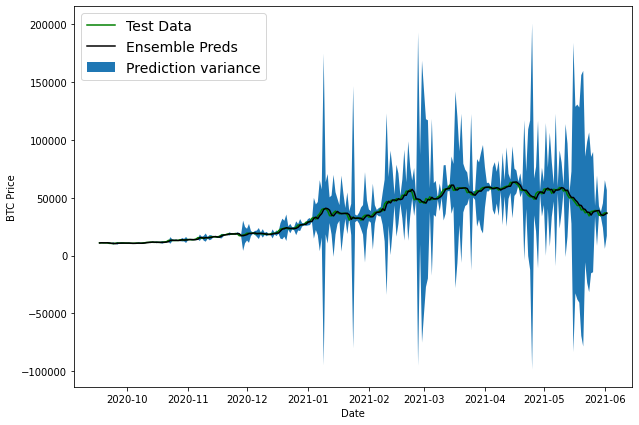

In [117]:
# Plot the variance/median of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

offset=300
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Preds")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (ensemble_median-ensemble_var)[offset:], 
                 (ensemble_median+ensemble_var)[offset:], label="Prediction variance")
plt.legend(loc="upper left", fontsize=14);

Making future forecast on models 

In [118]:
bitcoin_prices_windowed

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.654990,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,25,123.654990,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.584830,25,125.455000,123.654990,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.674660,25,108.584830,125.455000,123.654990,NaN,NaN,NaN,NaN
2013-10-05,121.338660,25,118.674660,108.584830,125.455000,123.654990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-05-29,34898.008720,6.25,38717.769220,38915.004829,38290.448528,38085.789361,34259.548416,37490.941888,36921.767808
2021-05-30,34535.522468,6.25,34898.008720,38717.769220,38915.004829,38290.448528,38085.789361,34259.548416,37490.941888
2021-05-31,35749.655692,6.25,34535.522468,34898.008720,38717.769220,38915.004829,38290.448528,38085.789361,34259.548416


In [119]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [120]:
#creating tensorflow windows for data
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_9.fit(X_all, y_all,
            epochs=10)

Epoch 1/10
88/88 [==============================] - 1s 2ms/step - loss: 594.1995
Epoch 2/10
88/88 [==============================] - 0s 3ms/step - loss: 334.2740
Epoch 3/10
88/88 [==============================] - 0s 2ms/step - loss: 291.8546
Epoch 4/10
88/88 [==============================] - 0s 1ms/step - loss: 265.8689
Epoch 5/10
88/88 [==============================] - 0s 2ms/step - loss: 299.7154
Epoch 6/10
88/88 [==============================] - 0s 1ms/step - loss: 273.8899
Epoch 7/10
88/88 [==============================] - 0s 2ms/step - loss: 269.7777
Epoch 8/10
88/88 [==============================] - 0s 1ms/step - loss: 309.8934
Epoch 9/10
88/88 [==============================] - 0s 1ms/step - loss: 328.4095
Epoch 10/10
88/88 [==============================] - 0s 4ms/step - loss: 284.6776


In [121]:
# Make predictions on the future

# List for new preds
future_forecast = []
last_window = y_all[-WINDOW_SIZE:] # get the last window of the training data
into_future = 14 # how far to predict into the future

for i in range(into_future):
    # Make a pred for the last window, then append the prediction, append it again, append it again
    pred = model_9.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(pred).numpy()}\n")
    future_forecast.append(tf.squeeze(pred).numpy())
    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, pred)[-WINDOW_SIZE:]

Predicting on: 
 [38915.0048286  38717.76921992 34898.00871956 34535.52246756
 35749.65569214 36929.47673981 36419.74950068] -> Prediction: 39198.91796875

Predicting on: 
 [38717.76921992 34898.00871956 34535.52246756 35749.65569214
 36929.47673981 36419.74950068 39198.91796875] -> Prediction: 37457.96875

Predicting on: 
 [34898.00871956 34535.52246756 35749.65569214 36929.47673981
 36419.74950068 39198.91796875 37457.96875   ] -> Prediction: 35203.95703125

Predicting on: 
 [34535.52246756 35749.65569214 36929.47673981 36419.74950068
 39198.91796875 37457.96875    35203.95703125] -> Prediction: 35418.0703125

Predicting on: 
 [35749.65569214 36929.47673981 36419.74950068 39198.91796875
 37457.96875    35203.95703125 35418.0703125 ] -> Prediction: 36749.0234375

Predicting on: 
 [36929.47673981 36419.74950068 39198.91796875 37457.96875
 35203.95703125 35418.0703125  36749.0234375 ] -> Prediction: 37478.47265625

Predicting on: 
 [36419.74950068 39198.91796875 37457.96875    35203.957

In [122]:
future_forecast[:10]

[39198.918,
 37457.97,
 35203.957,
 35418.07,
 36749.023,
 37478.473,
 37641.215,
 38909.816,
 36908.094,
 35813.438]

In [123]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-06-02 00:00:00')

In [124]:
def get_future_dates(start_date, horizon=1, offset=1):

  #Returns array of datetime values from ranging from start_date to start_date+horizon.
   return np.arange(start_date + np.timedelta64(offset, "D"), start_date + np.timedelta64(horizon+1, "D"), dtype="datetime64[D]")

In [125]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, horizon=into_future)
next_time_steps

array(['2021-06-03', '2021-06-04', '2021-06-05', '2021-06-06',
       '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
       '2021-06-11', '2021-06-12', '2021-06-13', '2021-06-14',
       '2021-06-15', '2021-06-16'], dtype='datetime64[D]')

In [131]:
# Add in extra timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-06-02', '2021-06-02', '2021-06-03', '2021-06-04',
        '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
        '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
        '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16'],
       dtype='datetime64[D]'),
 array([36419.75 , 39198.918, 37457.97 , 35203.957, 35418.07 , 36749.023,
        37478.473, 37641.215, 38909.816, 36908.094, 35813.438, 36380.35 ,
        37635.195, 38105.363, 38375.89 ], dtype=float32))

ValueError: x and y must have same first dimension, but have shapes (16,) and (15,)

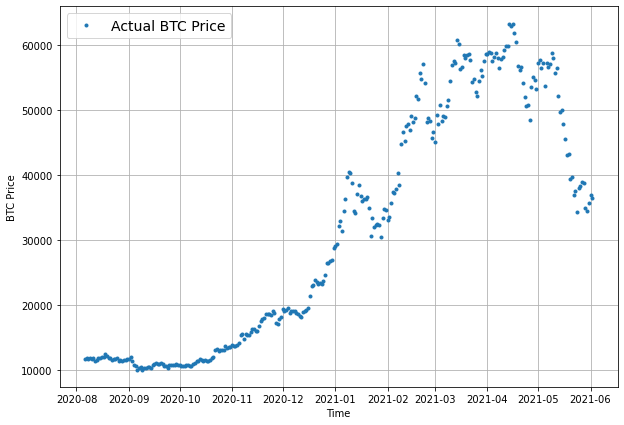

In [132]:
# TODO: if we predict far enough into the future we start to see what happens to our model's forecasts... (they begin to break down)
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, label="Predicted BTC Price")